In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
 
pd.set_option('display.max_rows', 500)

In [15]:
class Price(object):
    def __init__(self, f_name = None):
        if(isinstance(f_name, str)):
            data = pd.read_csv(
                f_name,
                names=["date", "close", "open", "high", "low", "volume",'ratio'],
                header=0
            )
            data["date"] = pd.to_datetime(data["date"], format="%Y年%m月%d日")
            # remove
            for c in ["close", "open", "high", "low"]:
                data = self._decoder(data, c)
            self.origin = data.sort_values(by="date").reset_index(drop=True)
        else:
            self.origin = None
        
    def _decoder(self, data, col):
        data[col] = data[col].apply(lambda x: float(x.replace(",", "")))
        return data
        
    def show_price(self):
        plt.plot(self._date(), self._close())
    
    def _date(self):
        return self.origin.loc[:, "date"]
    
    def _close(self):
        return self.origin.loc[:, "close"]
    
    def historical_vol(self):
        return np.diff(np.log(self.origin["close"]))*100
    
    def profit_rate(self, idx1, idx2):
        p1 = self.origin.iloc[idx1].close
        p2 = self.origin.iloc[idx2].close
        if (p1 > 0 and p2 > 0):
            return 100 * (p2-p1)/p1
        else:
            return None
        
    
class SMA(object):
    
    def __init__(self, f_name, title, periods):
        self.price = Price(f_name)
        self.df = self.price.origin
        self.title = title
        self.periods = periods
        
    def data(self):
        return self.df
    
    def add_sma(self, col, period):
        sma_n = self.df[col].rolling(period).mean()
        self.df["{}_sma_{}".format(col, period)] = sma_n
        return self.df

    def drop_sma(self, col):
        self.df = self.df.drop(col, axis=1)
        
    def find_sma_cross(self):
        df = self.df
        periods = self.periods
        df["buy"] = df.apply(lambda x: self._cmp(x, "close_sma_{}".format(periods[-2]), "close_sma_{}".format(periods[-1])), axis=1)
        df["sell"] = df.apply(lambda x: self._cmp(x, "close_sma_{}".format(periods[1]), "close_sma_{}".format(periods[0])), axis=1)
        df["position"] = "open"
            
        df["golden_cross"] = 0
        for n in df[df.buy == 1].index:
            prev = df.iloc[n-1]["buy"]
            if n <= 0 or np.isnan(prev):
                continue
            elif prev == 0:
                df.loc[n, "golden_cross"] = 1
        df["death_cross"] = 0
        for n in df[df.sell == 1].index:
            prev = df.iloc[n-1]["sell"]
            if n <= 0 or np.isnan(prev):
                continue
            elif prev == 0:
                df.loc[n, "death_cross"] = 1
                
        dx_list = np.array(df[df.death_cross == 1].index)
        for gx in df[df["golden_cross"] == 1].index:
            if df.iloc[gx]["position"] == "buy":
                continue
            if sum(dx_list > gx) == 0:
                continue
            dx = df.loc[dx_list[dx_list > gx]].index[0]
            
            df.loc[(gx+1):dx, "position"] = "buy"
            
        df = df.drop(["buy", "sell"], axis=1)
        self.df = df
    
    def _cmp(self, df, short_col, long_col):
        short = df[short_col]
        long = df[long_col]
        buy = 0
        if short > long:
            buy = 1
        return buy
        
    def total_profit(self):
        self.df["profit_rate"] = 0
        self.df["holding_period"] = 0
        death_df = self.df[self.df["death_cross"] == 1]
        
        for gx_index in self.df[(self.df.golden_cross == 1) & (self.df.position == "open")].index:
            dx_df = death_df[death_df.index > gx_index]
            if(len(dx_df)>0):
                dx_index = dx_df.iloc[0].name
                prft_rate = self.price.profit_rate(gx_index, dx_index)
                if prft_rate:
                    self.df.loc[dx_index, "profit_rate"] = prft_rate
                    
                    self.df.loc[dx_index, "holding_period"] = dx_index - gx_index
        
    def add_all_sma(self, col):
        for p in self.periods:
            self.add_sma(col, p)
            
    def plot_sma(self, save):
        grid_spec = { "height_ratios": [2, 1] }
        fig, (axH, axL) = plt.subplots(nrows=2, sharex=True, figsize=(20, 5), gridspec_kw=grid_spec, dpi=200)
        fig.tight_layout()
        cmap = plt.get_cmap("tab10")
        
        # Stock price
        axH.grid()
        axL.set_xlabel("Date")
        axL.grid()
        axH.set_ylabel("Stock price [yen]")
        
        axH.plot(self.df["date"], self.df["close"])
        if(len(self.periods) > 0):
            title = "{0}".format(self.title)
            for (i, p) in enumerate(self.periods):
                title = title + "-SMA{0}".format(p)
                axH.plot(self.df["date"], self.df["close_sma_{}".format(p)], color=cmap(i+7))
        axH.set_title(title)
        
        death_df = self.df[self.df["death_cross"] == 1]
        for gx_index in self.df[(self.df.golden_cross == 1)&(self.df.position == "open")].index:
            
            dx_df = death_df[death_df.index > gx_index]
            if(len(dx_df)>0):
                dx_index = dx_df.iloc[0].name
                axH.axvspan(self.df.iloc[gx_index].date, self.df.iloc[dx_index].date, color="green", alpha=0.2)
            
        # Profit rate
        axL.set_ylabel("Profit rate [%]")
        profit_df = self.df[(self.df.death_cross == 1) & (self.df.profit_rate != 0)]
        axL.plot(profit_df["date"], profit_df["profit_rate"], linewidth=2, color="purple", marker="o")
        mean_profit = self.mean_profit()
        axL.axhline(y=mean_profit, color='r', linestyle='-')
        axL2 = axL.twinx()
        axL2.bar(self.df['date'], self.df["holding_period"], width=30, alpha=0.5, color="orange")
        axL2.set_ylabel("Holding period [days]")

        
        if save:
            os.makedirs("./result/{}".format(self.title), exist_ok=True)

            fig.savefig("./result/{}/{}.png".format(self.title, title))
            plt.close()


    def mean_profit(self):
        df = self.df[self.df.profit_rate != 0]
        return df.profit_rate.dropna().mean()
    
    def mean_period(self):
        df = self.df[self.df.holding_period != 0]
        return df.holding_period.dropna().mean()
    
    def trading_count(self):
        df = self.df[self.df.profit_rate != 0]
        return df.profit_rate.dropna().count()
        
    @staticmethod
    def estimate(f_name=None, title="Nikkei", periods = [], save = False):
        periods = sorted(periods)
        sma = SMA(f_name, title, periods)
        sma.add_all_sma("close")
        sma.find_sma_cross()
        sma.total_profit()
        sma.plot_sma(save)
        return [sma.mean_profit(), sma.mean_period(), sma.trading_count()]

    
    @staticmethod
    def evaluate_all(f_name=None, title="Nikkei", periods = []):
        from itertools import combinations
        from joblib import Parallel, delayed
        
        dump = []
            
        for n in [2, 3]:
            dump.extend(Parallel(n_jobs=-1, verbose=3)(
                [delayed(wrap)(f_name, title, comb) for comb in combinations(periods, n)]))
            
        pd.DataFrame(dump, columns=["f_name", "title", "sma", "mean_profit", "mean_holding", "trading_count"]).to_csv("./result/{}/{}.csv".format(title, title))
        return 0

def wrap(f_name, title, periods):
    print("{}, {}, {}".format(f_name, title, periods))
    mean_profit, mean_period, trading_count = SMA.estimate(f_name, title, periods, True)
    result = [f_name, title, periods, mean_profit, mean_period, trading_count]
    return result
        

In [17]:
SMA.evaluate_all("./data/stock/nikkei_2005-01-03_2020-08-11.csv", "nikkei", [10, 20, 30, 40, 50, 100, 200])
SMA.evaluate_all("./data/stock/lasertec_2012-03-15_2020-08-11.csv", "lasertec", [10, 20, 30, 40, 50, 100, 200])
SMA.evaluate_all("./data/stock/TOYOTA_2005-01-03_2020-08-11.csv", "toyota", [10, 20, 30, 40, 50, 100, 200])
SMA.evaluate_all("./data/stock/softbank_2005-01-03_2020-08-11.csv", "softbank", [10, 20, 30, 40, 50, 100, 200])
SMA.evaluate_all("./data/stock/UFJ_2001-04-03_2020-08-11.csv", "ufj", [10, 20, 30, 40, 50, 100, 200])
SMA.evaluate_all("./data/stock/nintendo_2005-01-04_2020-08-11.csv", "nintendo", [10, 20, 30, 40, 50, 100, 200])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Pa

0

In [18]:
nikkei = pd.read_csv("./result/Nikkei/nikkei.csv", index_col=0).sort_values(by="mean_profit", ascending=False)
lasertec = pd.read_csv("./result/Lasertec/lasertec.csv", index_col=0).sort_values(by="mean_profit", ascending=False)
toyota = pd.read_csv("./result/Toyota/toyota.csv", index_col=0).sort_values(by="mean_profit", ascending=False)
softbank = pd.read_csv("./result/Softbank/softbank.csv", index_col=0).sort_values(by="mean_profit", ascending=False)
ufj = pd.read_csv("./result/UFJ/ufj.csv", index_col=0).sort_values(by="mean_profit", ascending=False)

tmp = pd.concat([pd.concat([nikkei, lasertec]), pd.concat([toyota, softbank])])
nintendo = pd.read_csv("./result/Nintendo/nintendo.csv", index_col=0).sort_values(by="mean_profit", ascending=False)

whole = pd.concat([pd.concat([tmp, nintendo]), ufj])

#2 株価データの概要

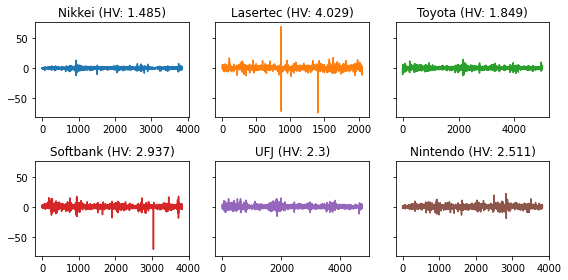

In [19]:
f_list = [
    "./data/stock/nikkei_2005-01-03_2020-08-11.csv",
    "./data/stock/lasertec_2012-03-15_2020-08-11.csv",
    "./data/stock/TOYOTA_2005-01-03_2020-08-11.csv",
    "./data/stock/softbank_2005-01-03_2020-08-11.csv",
    "./data/stock/UFJ_2001-04-03_2020-08-11.csv",
    "./data/stock/nintendo_2005-01-04_2020-08-11.csv"
]
titles = ["Nikkei", "Lasertec", "Toyota", "Softbank", "UFJ", "Nintendo"]

fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(8, 4))
cmap = plt.get_cmap("tab10")

for (idx, f)  in enumerate(f_list):
    ldp = Price(f).historical_vol()
    if idx < 3:
        axes[0, idx % 3].plot(ldp, color=cmap(idx))
        axes[0, idx % 3].set_title("{} (HV: {})".format(titles[idx], round(np.std(ldp), 3)))
    else:
        axes[1, idx % 3].plot(Price(f).historical_vol(), color=cmap(idx))
        axes[1, idx % 3].set_title("{} (HV: {})".format(titles[idx], round(np.std(ldp), 3)))
fig.tight_layout()

値動きが激しい株を調べるために、ヒストリカル・ボラティリティ(HV)を表示した。
グラフは対数差分収益率を表しており、価格変動の激しさを示している。タイトル横のHVがヒストリカル・ボラティリティを示す。


レーザーテックとソフトバンクが特に価格変動が大きい

In [20]:
print(whole.groupby("title").mean().sort_values("mean_profit", ascending=False))

mean_profit  mean_holding  trading_count
title                                             
nintendo     8.962977     67.065910      29.285714
lasertec     6.563421     57.409251      16.107143
softbank     4.051687     56.946329      28.696429
toyota       3.199149     58.558673      38.732143
nikkei       2.496271     63.347594      29.535714
ufj          1.161398     50.012738      37.803571


企業ごとに見ると、任天堂が8.9%、レーザーテックが利率6.5%と高く、UFJが1.16%と低くなっている。
株を所持する日数に際立った違いはない。

レーザーテックを見ると、ボラティリティの高さが影響しているように見える。
一方で、同程度のボラティリティを持つ任天堂とUFJが全く異なる利益率を示すことから、ボラティリティの値と利益率には直結していない。

In [21]:
sma_group = whole.groupby("sma").mean().sort_values(by="mean_profit", ascending=False)
sma_group.head(8)

,mean_profit,mean_holding,trading_count
sma,,,
"(100, 200)",25.236503,214.568787,9.666667
"(50, 200)",12.469672,167.546813,11.500000
"(40, 200)",11.059071,158.847899,11.833333
"(20, 100, 200)",10.040179,102.630736,9.666667
"(30, 100, 200)",9.638181,113.291065,9.500000
"(30, 100)",9.256767,100.355360,20.500000
"(10, 100, 200)",8.698826,90.378698,10.000000
"(40, 100)",8.577925,103.667030,20.000000


100日と200日の二点交差がもっとも利益率が高い。同様に株を保持する期間も平均206日と極端に長い。

二点交差でもっとも性能が良かったのは、40日と100日の組み合わせだった。

三点交差でもっとも性能が良かったのは、30, 50, 100日の組み合わせだった。

短期・中期・長期の組み合わせで利益率が高くなる様子がわかる。

<AxesSubplot:xlabel='sma', ylabel='mean_profit'>

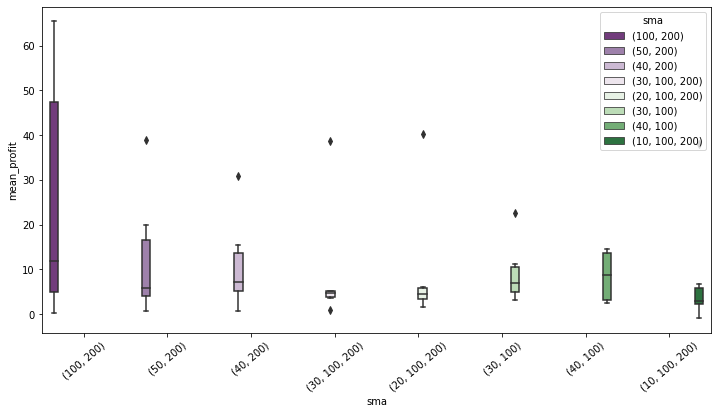

In [22]:
sma_list = ["(100, 200)", "(50, 200)", "(40, 200)", "(20, 100, 200)", "(30, 100, 200)", "(30, 100)", "(10, 100, 200)", "(40, 100)"]
plt.figure(figsize=(12, 6))
plt.xticks(rotation=40)

sns.boxplot(x='sma', y="mean_profit", hue="sma", data=whole[whole["sma"].isin(sma_list)], palette="PRGn")

利益率の分布を見ると、ほとんどのSMAは極端に高い利益率を１つ含んでいる。これによって平均利益率が底上げされている様子がわかる。

sma
(100, 200)    243.952861
(10, 100)     207.942899
(30, 100)     189.763723
(10, 20)      179.524062
(20, 100)     174.903841
(40, 100)     171.558503
(10, 30)      166.148949
(50, 100)     165.922748
dtype: float64
sma
(20, 50, 200)     6.161021
(40, 50, 200)    11.709621
(30, 50, 200)    12.845969
(10, 50, 200)    13.108145
(20, 40, 200)    18.526194
(10, 20, 200)    18.983528
(10, 20, 100)    26.371222
(30, 40, 200)    30.037808
dtype: float64


<AxesSubplot:xlabel='sma'>

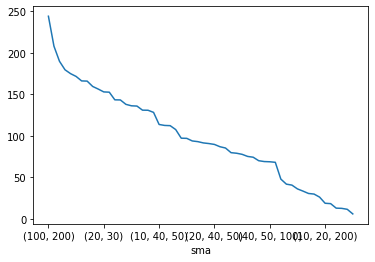

In [23]:
profit_result = (sma_group["mean_profit"] * sma_group["trading_count"])
print(profit_result.sort_values(ascending=False).head(8))
print(profit_result.sort_values(ascending=True).head(8))
profit_result.sort_values(ascending=False).plot()

三点交差は取引回数が全体的に少なくなり、結果的に全体の利益が低下した。

100日と200日の二点交差は利益率と同じくもっとも利益が高くなり、ついで10日と100日が良い結果を出した。